# SPEED analysis

First we ASSEMBLE it, after that its been LABELED. Then its PACKAGED and these going into a CARTON. At last the Cartons get PALLETIZED   
It goes from Assembly (Harro Hoefliger) to Labeler (Krones) to Packaging (Schubert Verpacker) to Cartoner (Pester Umverpacker) to Palletizer (Pester)




|IP_TAG Name   |Machine|German|Optimum Speed|Alarm File location|
|--------------|-------|------|-------------|-------------------| 
|36630901_SPEED|Assembly|Montage|32 used but 35|Y:\E00_Solostar\E6_Assembly_Line_6\E63_Montage\CSV|   
|36640901_SPEED|Labeler|Etikettierer|500|Y:\E00_Solostar\E6_Assembly_Line_6\E64_Etikettierer\AuditTrail|   
|36650901_SPEED|Packaging (Pacemaker!)|Kartonierer|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E65_Kartonierer\40 - Reports|   
|36680901_SPEED|Cartoner|Endverpacker (UVP)|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\UVP|   
|36680902_SPEED|Palletizer|PAL|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\PAL|       

adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (always 50)

In [612]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                print("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [613]:
import pandas as pd
import numpy as np
import os
import re
from glob import iglob

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns


In [616]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

df = []
df_speed = pd.DataFrame()

# do a recursive search for the files now we have multiple dirs
for filename in iglob(path + '/**/*_SPEED.csv', recursive=True):
    df = pd.read_csv(filename)
    df_speed = df_speed.append(df)




In [627]:
# get the packaging DESIGNATION file which shows the pcs format
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

df = []
df_designation = pd.DataFrame()

# do a recursive search for the files now we have multiple dirs
for filename in iglob(path + '/**/*36650901_DESIGNATION.csv', recursive=True):
    df = pd.read_csv(filename)
    df_designation = df_designation.append(df)

# just keep the Good QLEVEL and VALUEs like 'FS...'
df_designation = df_designation[(df_designation.IP_TREND_QLEVEL == 'Good') & (df_designation.IP_TREND_VALUE.str.contains('FS'))]


Tags for Machine speeds:

|IP_TAG Name   |Machine|Optimum Speed|
|--------------|-------|------------|
|36630901_SPEED|Assembly|32 steps x16 lines (= 512) used but max could be 35 steps|   
|36640901_SPEED|Labeler|500 pcs / min|   
|36650901_SPEED|Packaging (Pacemaker!)|3pcs per package x 150 steps = 450/min, or 5pcs per package x 100 steps = 500/min|   
|36680901_SPEED|Cartoner|aka UVP - 500 max derived from upstream|   
|36680902_SPEED|Palletizer|aka PAL - 500 max derived from upstream|    

In [628]:
# convert dates to datetime format
df_speed['IP_TREND_TIME'] = pd.to_datetime(df_speed['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation['IP_TREND_TIME'] = pd.to_datetime(df_designation['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation = df_designation.sort_values('IP_TREND_TIME')
# df_speed.set_index('IP_TREND_TIME', inplace=True)

In [629]:
# df_designation.info()
df_speed = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_designation[['IP_TREND_TIME','IP_TREND_VALUE']].sort_values('IP_TREND_TIME'),on='IP_TREND_TIME', allow_exact_matches=True)
# rename IP_TREND_VALUE_y Format to avoid confusion
df_speed.rename(columns={'IP_TREND_VALUE_y':'Format',
                         'IP_TREND_VALUE_x':'IP_TREND_VALUE'}, inplace=True)

In [630]:
df_speed.head()

,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Format
0,36650901_SPEED,2021-08-01 00:07:42.800,0,Good,Good,NaN
1,36630901_SPEED,2021-08-01 00:08:10.500,0,Good,Good,NaN
2,36640901_SPEED,2021-08-01 00:08:16.700,0,Good,Good,NaN
3,36680901_SPEED,2021-08-01 00:08:42.400,0,Good,Good,NaN
4,36680902_SPEED,2021-08-01 00:09:14.200,0,Good,Good,NaN


In [631]:
# label the rows with the Machine name
df_speed['Machine'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Machine'] = 'Assembly'
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Machine'] = 'Labeler'
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Machine'] = 'Packaging'
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Machine'] = 'Cartoner'
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Machine'] = 'Palletizer'

# set the Max_Speeds
df_speed['Max_Speed'] = ''
df_speed.loc[df_speed['Machine'] == 'Assembly', 'Max_Speed'] = (32*16)
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Max_Speed'] = 500
# set the packaging machine to default 450 Max_Speed
df_speed.loc[df_speed['Machine'] == 'Packaging', 'Max_Speed'] = 450
# dont know what the max speeds of Cartoner and Palletizer are, so derived from upstream max
df_speed.loc[df_speed['Machine'] == 'Cartoner', 'Max_Speed'] = 450
df_speed.loc[df_speed['Machine'] == 'Palletizer', 'Max_Speed'] = 450
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Cartoner'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = 500


# adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (50)
# assembly value is multipied by 16 (lines)
df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'] = df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'].mul(16)
# Packaging IP_TREND_VALUE is multiplied by pcs format - we can use the Max_Speed now to work that out
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)

# create a new derived_speed col and leave the IP_TREND_VALUE as raw data
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)

# and just copy the IP_TREND_VALUE across for the assembly and labeler as no adjustments made
df_speed.loc[df_speed['Machine'] == 'Assembly', 'Derived_Speed'] = df_speed.loc[df_speed['Machine'] == 'Assembly', 'IP_TREND_VALUE']
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Derived_Speed'] = df_speed.loc[df_speed['Machine'] == 'Labeler', 'IP_TREND_VALUE']

In [632]:
# take dates found in df_speed
start_date = df_speed.IP_TREND_TIME.min()
end_date = df_speed.IP_TREND_TIME.max()

daterange = pd.date_range(start = start_date, end = end_date, freq='S')

df_dates = pd.DataFrame(daterange)
df_dates.rename(columns={0:'datetime'}, inplace=True)
# df_dates.set_index(0, inplace=True)

In [633]:

df_speed2 = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_dates.sort_values('datetime'), right_on='datetime', left_on='IP_TREND_TIME', tolerance=pd.Timedelta("1s"), direction='backward', allow_exact_matches=True)
df_speed = pd.merge(df_dates, df_speed2, on='datetime', how='left')
df_speed.set_index('datetime', inplace=True)

# CHANGEOVER

In [634]:
# CHANGEOVER
folder = 'IP21_data'

df = []
df_BATCHACTIVE = pd.DataFrame()

path = os.path.join(dir_sanofi_share, folder)

# do a recursive search for the files now we have multiple dirs
for filename in iglob(path + '/**/*36680902_BATCHACTIVE*', recursive=True):
    df = pd.read_csv(filename)
    df_BATCHACTIVE = df_BATCHACTIVE.append(df)


df = []
df_CNTR_GOOD = pd.DataFrame()

path = os.path.join(dir_sanofi_share, folder)

# do a recursive search for the files now we have multiple dirs
for filename in iglob(path + '/**/*36680902_CNTR_GOOD*', recursive=True):
    df = pd.read_csv(filename)
    df_CNTR_GOOD = df_CNTR_GOOD.append(df)

# for filename in os.listdir( path ):
#     # this will only find files for Assembly and Packaging
#     if '36680902_BATCHACTIVE' in filename:
#         path = os.path.join(dir_sanofi_share, folder, filename)
#         df_BATCHACTIVE = pd.read_csv(path)

#     if '36680902_CNTR_GOOD' in filename:
#         path = os.path.join(dir_sanofi_share, folder, filename)
#         df_CNTR_GOOD = pd.read_csv(path)
        
df_CNTR_GOOD = df_CNTR_GOOD.sort_values('IP_TREND_TIME')
df_BATCHACTIVE = df_BATCHACTIVE.sort_values('IP_TREND_TIME')


In [635]:
df_changeover = []
# find where previous row was -1 (active) and this row is 0 (inactive) - this is the start of changeover
df_changeover = df_BATCHACTIVE[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_BATCHACTIVE['IP_TREND_VALUE'].shift(1) == -1) & (df_BATCHACTIVE['IP_TREND_VALUE'] == 0)]

# find where previous row was 0 (batch not started) and this row is >1 (batch running) - changeover has finished
df_changeover = df_changeover.append(df_CNTR_GOOD[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_CNTR_GOOD['IP_TREND_VALUE'].shift(1) == 0) & (df_CNTR_GOOD['IP_TREND_VALUE'] > 0)])
df_changeover.sort_values('IP_TREND_TIME', inplace=True)

# now, in case there are many BATCHACTIVEs for 1 CNTR_GOOD, only get the first BATCHACTIVE 
df_changeover2 = df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 0) & (df_changeover['IP_TREND_VALUE'] > 0)]
df_changeover2 = df_changeover2.append(df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 0) & (df_changeover['IP_TREND_VALUE'] == 1)])

# add the first row of changeover if it is a BATCHACTIVE, otherwise it gets dropped by above logic
df_changeover2 = df_changeover2.append(df_changeover[:1].loc[df_changeover[:1].Name == '36680902_BATCHACTIVE'])
df_changeover2.sort_values('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_changeover2['IP_TREND_TIME'] = pd.to_datetime(df_changeover2['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')

# find the speed and time diff, turn into minutes
df_changeover2['time_diff_mins'] = df_changeover2.IP_TREND_TIME.diff().dt.seconds / 60
df_changeover2['time_diff_mins'].fillna(0, inplace=True)
df_changeover2['time_diff_mins'] = np.array(df_changeover2['time_diff_mins'], dtype=int)
# df_changeover2.set_index('IP_TREND_TIME', inplace=True)

# reshape the changeover dataframe so that we have a start and end time on 1 line - easier for charting later
df_changeover3 = pd.DataFrame({'start':df_changeover2.IP_TREND_TIME.iloc[::2].values, 'end':df_changeover2.IP_TREND_TIME.iloc[1::2].values, 'time_diff_mins':df_changeover2.time_diff_mins.iloc[1::2].values})
for i, row in df_changeover3.iterrows():
    print (i, row[0], row[1])

0 2021-08-02 22:47:04.100000 2021-08-02 23:33:13.200000
1 2021-08-02 23:33:13.200000 2021-09-02 13:22:38.700000
2 2021-09-02 13:22:38.700000 2021-08-03 21:08:45.100000
3 2021-08-03 21:08:45.100000 2021-09-03 22:42:38.400000
4 2021-09-03 22:42:38.400000 2021-08-04 02:05:46.100000
5 2021-08-04 02:05:46.100000 2021-08-04 07:37:14.500000
6 2021-08-04 07:37:14.500000 2021-09-04 04:36:38.500000
7 2021-09-04 04:36:38.500000 2021-09-04 10:16:56.400000
8 2021-09-04 10:16:56.400000 2021-09-04 15:54:10.100000
9 2021-09-04 15:54:10.100000 2021-09-04 22:20:16.700000
10 2021-09-04 22:20:16.700000 2021-08-05 20:50:02
11 2021-08-05 20:50:02 2021-08-06 03:04:38.500000
12 2021-08-06 03:04:38.500000 2021-08-06 12:55:08.100000
13 2021-08-06 12:55:08.100000 2021-09-06 15:37:25.900000
14 2021-09-06 15:37:25.900000 2021-08-07 00:00:18.300000
15 2021-08-07 03:10:52.900000 2021-08-07 03:10:52.900000
16 2021-09-07 07:06:12.400000 2021-09-07 07:06:12.400000
17 2021-09-08 06:12:45.200000 2021-09-08 06:12:45.20000

# STATE

In [636]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df = []
df_omac = pd.DataFrame()

# do a recursive search for the files now we have multiple dirs
for filename in iglob(path + '/**/*_OMACSTATE.csv', recursive=True):
    Files.append(filename)
    df = pd.read_csv(filename)
    df_omac = df_omac.append(df)


Files = []
df = []
df_run = pd.DataFrame()

path = os.path.join(dir_sanofi_share, folder)


# do a recursive search for the files now we have multiple dirs
for filename in iglob(path + '/**/*36640901_RUN.csv', recursive=True):
    Files.append(filename)
    df = pd.read_csv(filename)
    df_run = df_run.append(df)

In [637]:
# convert dates to datetime format
df_omac['IP_TREND_TIME'] = pd.to_datetime(df_omac['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_omac.set_index('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_run['IP_TREND_TIME'] = pd.to_datetime(df_run['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_run.set_index('IP_TREND_TIME', inplace=True)

In [638]:
df_omac['Machine'] = ''
df_omac.loc[df_omac['Name'] == '36630901_OMACSTATE', 'Machine'] = 'Assembly'
df_omac.loc[df_omac['Name'] == '36650901_OMACSTATE', 'Machine'] = 'Packaging'

df_run['Machine'] = ''
df_run.loc[df_run['Name'] == '36640901_RUN', 'Machine'] = 'Labeler'

In [639]:
# loop through the machines, sort the datetime index, and fine the time diff, write it out as secs (rather than leaving it as timedelta)
machines = df_omac.Machine.unique()

for x in machines:
    # df_omac['Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds
    df_omac.loc[df_omac.Machine == x, 'time_diff_secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds

In [640]:
df_speed = pd.merge_asof(df_speed, df_omac['IP_TREND_VALUE'].sort_index(), left_index=True, right_index=True, direction='forward')
df_speed.rename(columns={
    'IP_TREND_VALUE_x':'IP_TREND_VALUE',
    'IP_TREND_VALUE_y':'State'}, inplace=True)

In [641]:
# create a pens col derived from the Format column- if it contains '5' then it's 5 pens, else we assume it's 3 even if we haven't been told...
# so this might be a wrong assumption
df_speed['pens'] = np.where((df_speed.Format.str.contains('5')), 5, 3)

# find where previous row pens value is different to this row
df_speed[df_speed.pens.shift(1) != df_speed.pens]
df_speed[df_speed.Format.shift(1) != df_speed.Format]



,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Format,Machine,Max_Speed,Derived_Speed,State,pens
datetime,,,,,,,,,,,
2021-08-01 00:07:42.800,36650901_SPEED,2021-08-01 00:07:42.800,0.0,Good,Good,NaN,Packaging,450,0.0,3.0,5
2021-08-01 00:07:43.800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5
2021-08-01 00:07:44.800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5
2021-08-01 00:07:45.800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5
2021-08-01 00:07:46.800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:59:50.800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5
2021-09-30 23:59:51.800,36650901_SPEED,2021-09-30 23:59:52.000,9.0,Good,Good,FS 5er Toujeo,Packaging,500,45.0,6.0,5
2021-09-30 23:59:52.800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5


In [642]:
def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    # for spine in ax.spines:
        # ax.spines[spine].set_visible(False)
        
    for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_x = data_x[-1]
        right_most_y = data_y[-1]
        ax.annotate(
            line.get_label(),
            xy=(right_most_x, right_most_y),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            color=line.get_color(),
        )
    ax.legend().set_visible(False)

KeyError: 'Max_Speed'

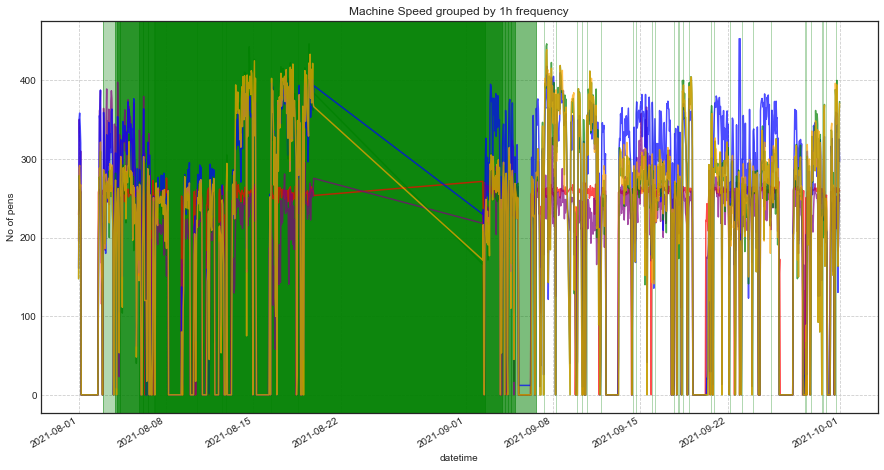

In [643]:
freq='1h'
group = df_speed.groupby(['Machine', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)


# control the order of the machines so they match the line design
# machines = group.Machine.unique()
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')
colors = ("red", "purple", "blue", "green", "orange")

i=0

fig, axs = plt.subplots(1, 1, figsize=(15, 8))

for x in machines:
    # group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    # plt.yscale('log')
    axs.grid(True,which="both", linestyle='--')
    axs.set_title('Machine Speed grouped by {} frequency'.format(freq))
    axs.set_ylabel('No of pens')

    i+=1

for i, row in df_changeover3.iterrows():
    plt.axvspan(row[0], row[1], color='green', alpha=0.3)

group['Max_Speed'][group.Machine == 'Packaging'].plot(color='black', ls=':', label='Theorical Max', ax=axs)

# axs.legend(loc='upper right', bbox_to_anchor=(1.16, 1.0))
improve_legend(axs)


axs.annotate('3 Pen Format', xy=('2021-08-05 00:00:04', 450),  xycoords='data',
            xytext=('2021-08-05 00:00:04', 475),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
axs.annotate('5 Pen Format', xy=('2021-08-16 00:36:52', 500),  xycoords='data',
            xytext=('2021-08-16 00:36:52', 475),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )  





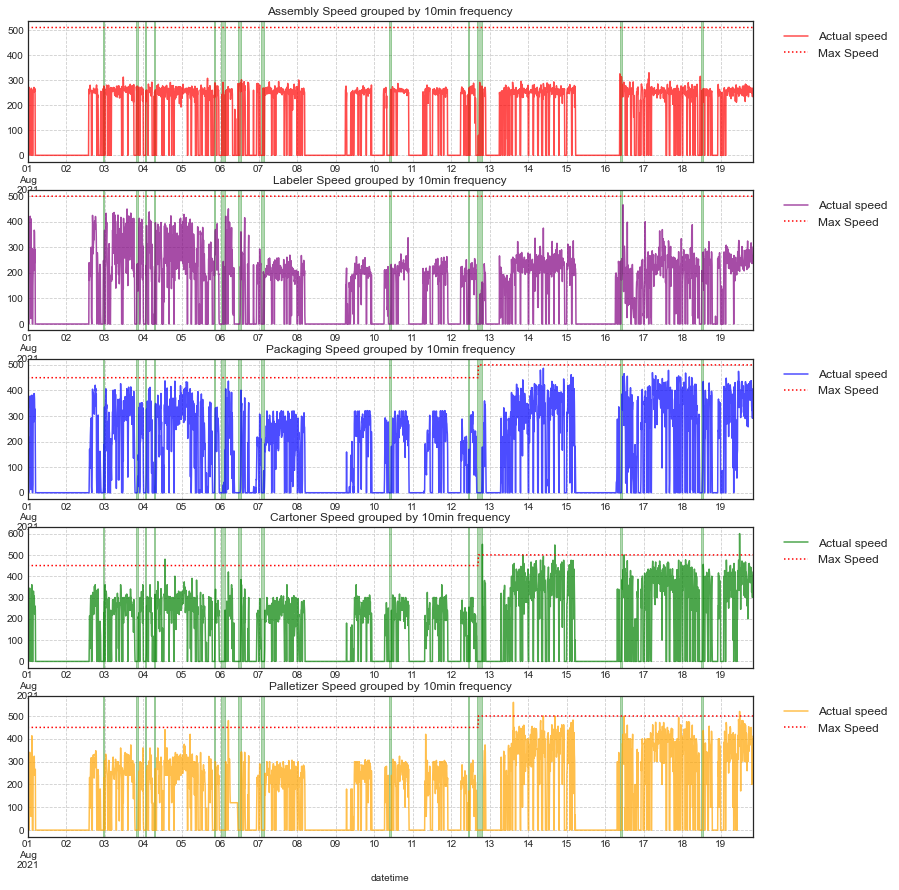

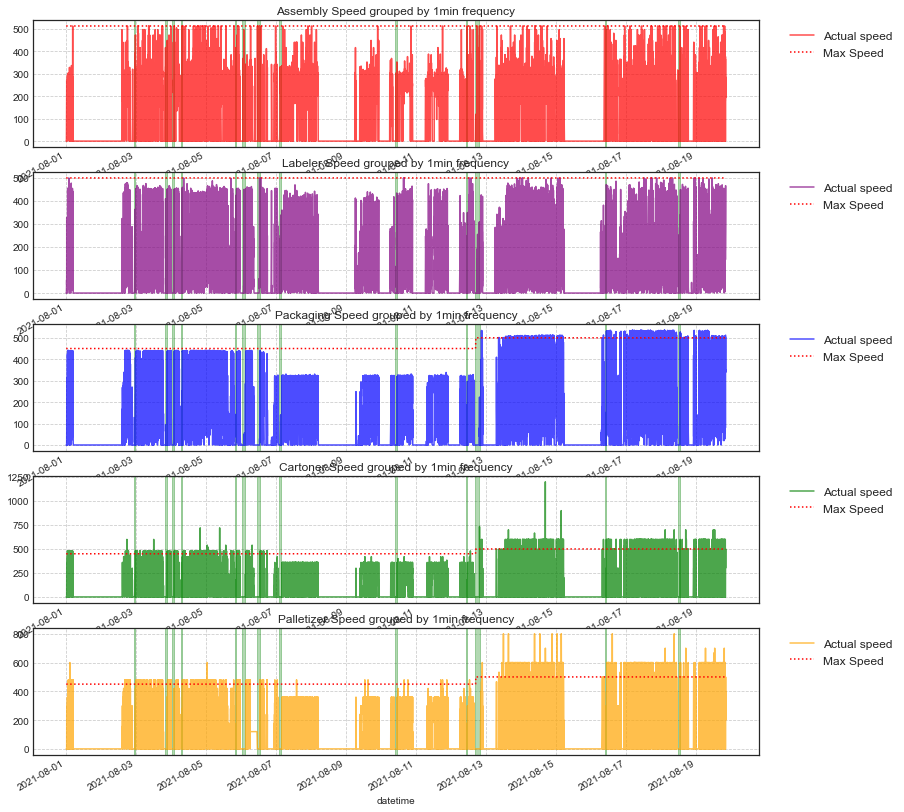

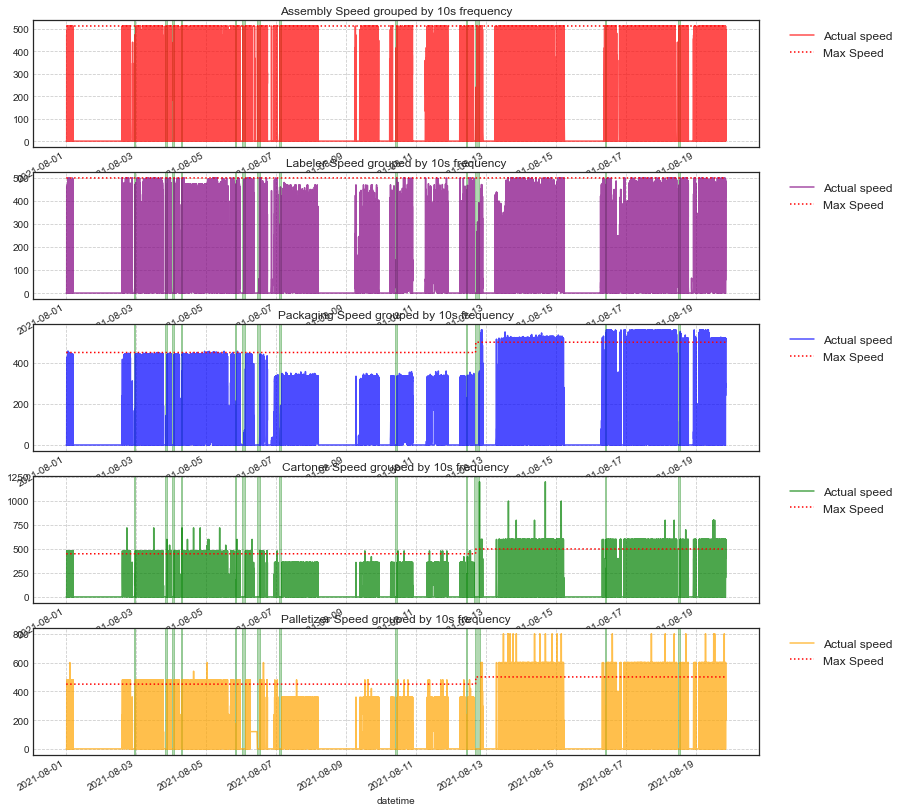

In [384]:
freq=('10min','1min','10s')

for f in freq:
    group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=f)]).mean().reset_index()
    group.set_index('datetime', inplace=True)

    # machines = group.Machine.unique()
    # control the order of the machines
    machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


    fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

    colors = ("red", "purple", "blue", "green", "orange")
    i=0

    for x in machines:
        group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label='Actual speed', ax=axs[i], alpha=0.7)
        # plt.yscale('log')

        if max(group['Max_Speed'][group.Machine == x]) > 0:
            group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

        axs[i].grid(True,which="both", linestyle='--')
        axs[i].set_title('{} Speed grouped by {} frequency'.format(x, f))

        for c, row in df_changeover3.iterrows():
            axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)

        plt.rc('legend', fontsize=12)    # legend fontsize
        axs[i].legend(loc='upper right', bbox_to_anchor=(1.20, 1.0), fancybox=True)

        # improve_legend(axs[i])


        i+=1

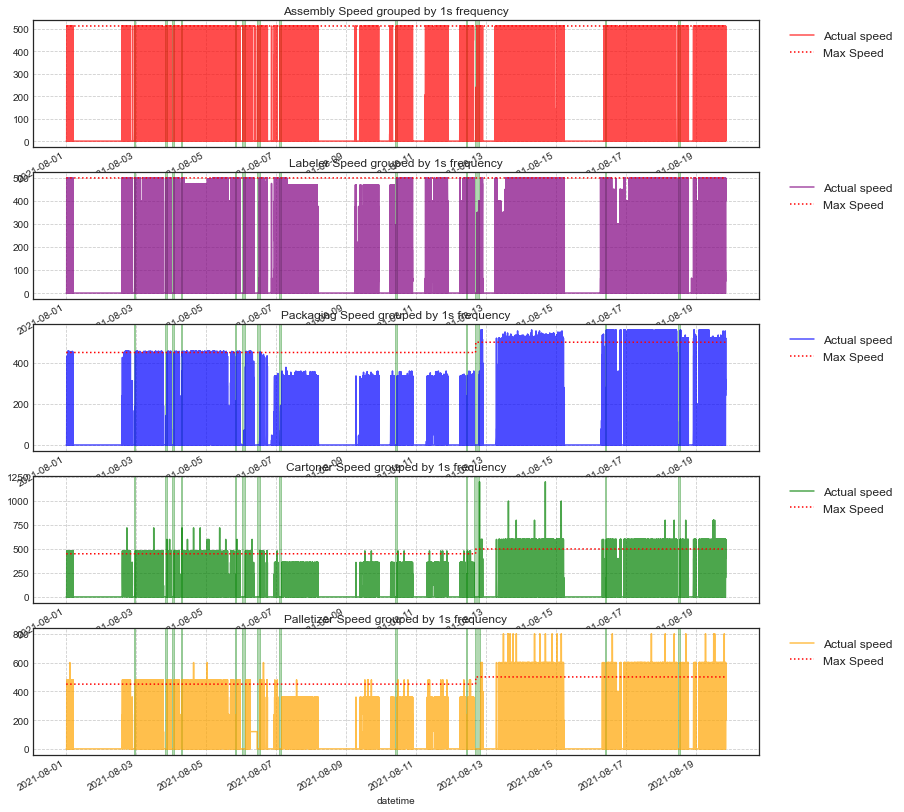

In [386]:
freq='1s'
group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

# machines = group.Machine.unique()
# control the order of the machines
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label='Actual speed', ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    if max(group['Max_Speed'][group.Machine == x]) > 0:
        group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed grouped by {} frequency'.format(x, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.20, 1.0), fancybox=True)
    
    for c, row in df_changeover3.iterrows():
        axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)    

    i+=1

In [24]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]
    # print('\nMax Speeds by {}\n'.format(f), round(max_hours.describe(),2))

    print('\n{} period\n'.format(f), round(max_hours.agg(['mean','max']),2))
    
# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()




Period: 2021-08-01 00:07:42.800000 to 2021-08-19 20:19:32.500000

1h period
          mean                                            max                                      
     Assembly Labeler Packaging Cartoner Palletizer Assembly Labeler Cartoner Packaging Palletizer
mean   175.77    1.24    165.89    53.10       1.24   360.55    2.31    345.4     82.72       2.28
max    279.73    2.76    397.79   129.27       2.68   512.00    6.00    500.0    152.00       5.00

30min period
          mean                                            max                                      
     Assembly Labeler Packaging Cartoner Palletizer Assembly Labeler Cartoner Packaging Palletizer
mean   161.01    1.13    153.39    48.19       1.13    328.4    2.01   316.57     74.44       1.99
max    292.00    2.88    414.77   144.00       2.96    512.0    6.00   500.00    152.00       5.00

10min period
          mean                                            max                                      
 


Period: 2021-08-01 00:07:42.800000 to 2021-08-19 20:19:32.500000


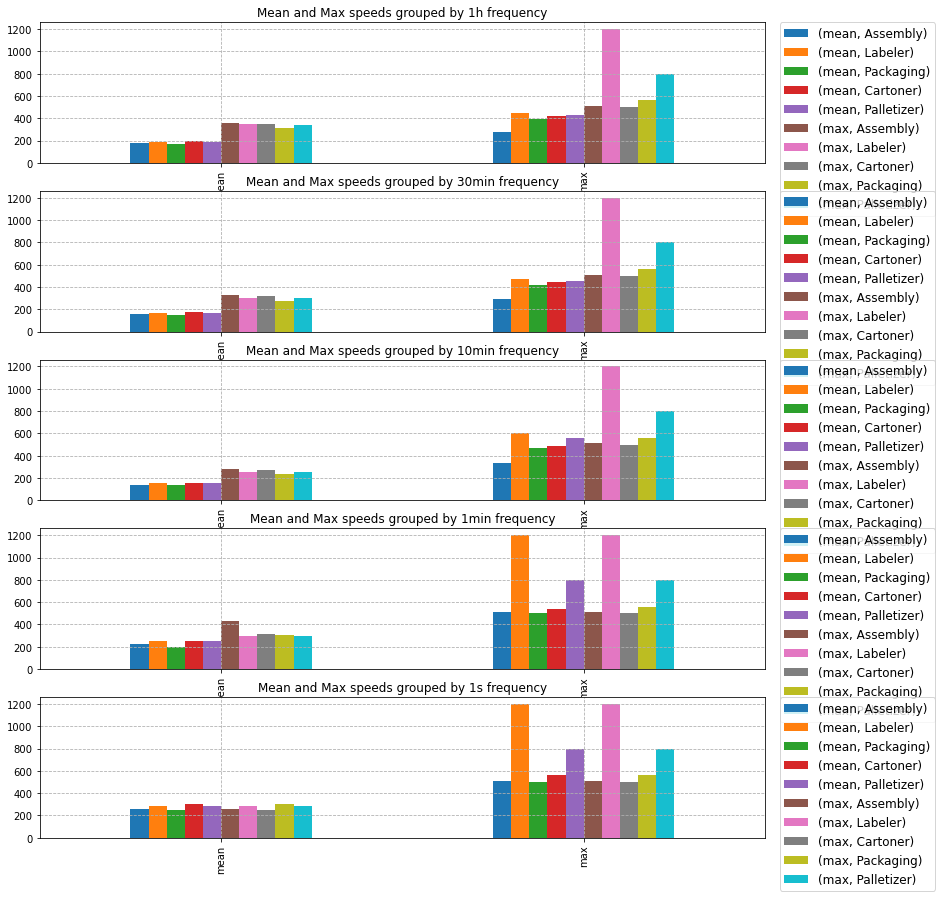

In [25]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

fig, axs = plt.subplots(len(freq), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['Derived_Speed'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]

    max_hours.agg({'mean','max'}).sort_index(ascending=False).plot.bar(ax=axs[i])

    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('Mean and Max speeds grouped by {} frequency'.format(f))
    plt.rc('legend', fontsize=12)    # legend fontsize
    #place legend outside top right corner of plot
#     handles, labels = axs[i].get_legend_handles_labels()
#     axs[i].legend(handles, labels)
    axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    i+=1

# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()



In [26]:
max_hours = df_speed.groupby([pd.Grouper(freq='1s'),'Machine'])['Derived_Speed'].agg(['mean','max']).unstack()

In [27]:
max_hours.agg({'mean','max'})

mean                                                          max                                                 
        Assembly     Cartoner     Labeler   Packaging  Palletizer    Assembly     Cartoner     Labeler   Packaging  Palletizer
mean  254.900697   285.371287  253.005197  306.683199  284.113866  255.291099   285.378713  253.149309  306.683772  284.113866
max   512.000000  1200.000000  500.000000  560.000000  800.000000  512.000000  1200.000000  500.000000  560.000000  800.000000

In [28]:
max_hours.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276188 entries, 2021-08-01 00:07:42 to 2021-08-19 20:19:31
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   (mean, Assembly)    101024 non-null  float64
 1   (mean, Cartoner)    16160 non-null   float64
 2   (mean, Labeler)     90718 non-null   float64
 3   (mean, Packaging)   96930 non-null   float64
 4   (mean, Palletizer)  16335 non-null   float64
 5   (max, Assembly)     101024 non-null  float64
 6   (max, Cartoner)     16160 non-null   float64
 7   (max, Labeler)      90718 non-null   float64
 8   (max, Packaging)    96930 non-null   float64
 9   (max, Palletizer)   16335 non-null   float64
dtypes: float64(10)
memory usage: 23.2 MB


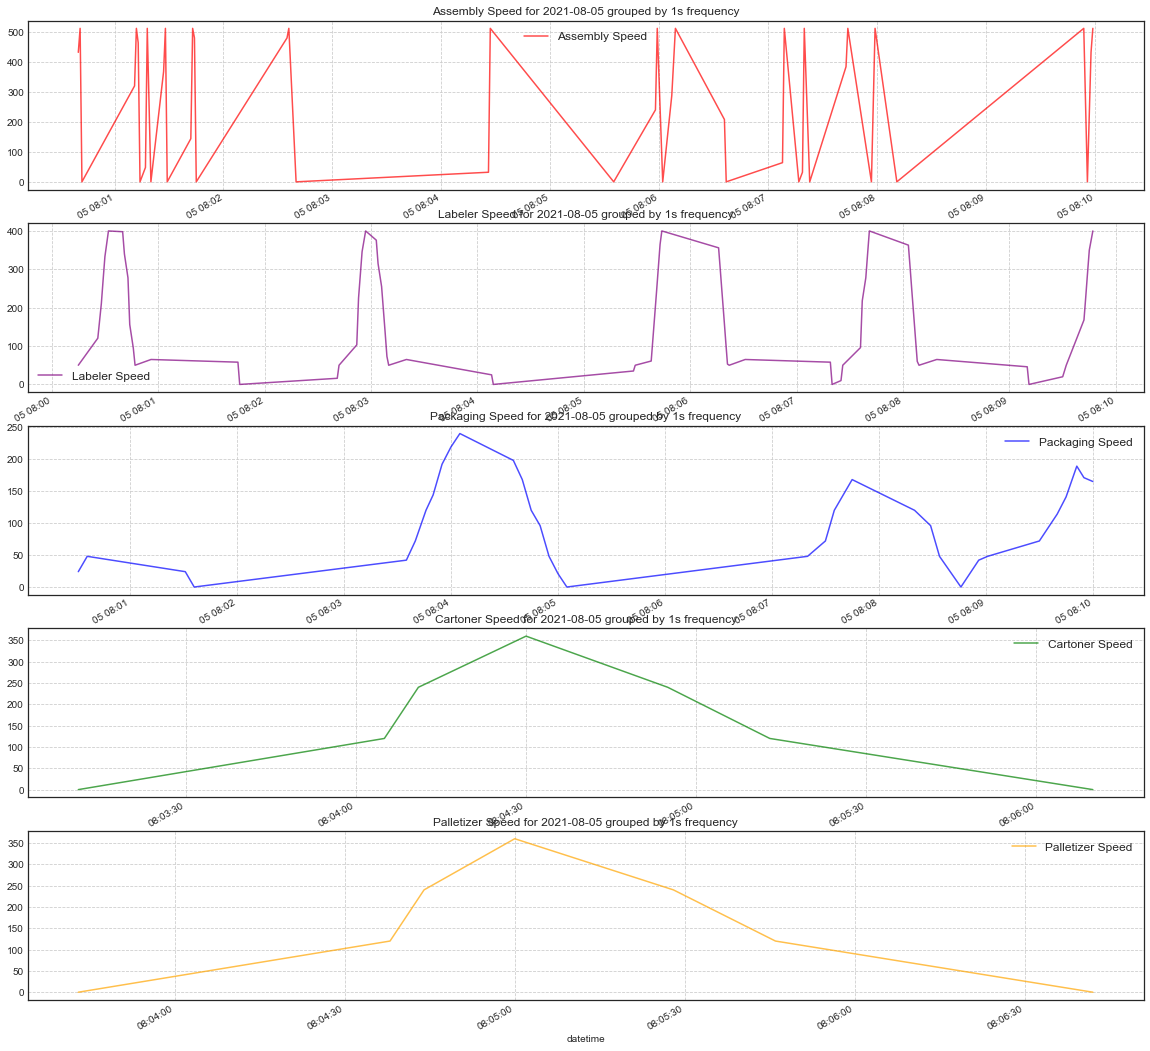

In [169]:
daterange = '2021-08-05'
times = ['08:00', '08:10']
freq='1s'

dates = group.loc[daterange]
dates = dates.between_time(times[0], times[1])

dates = dates.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
dates.set_index('datetime', inplace=True)


fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    dates['Derived_Speed'][dates.Machine == x].plot(color=colors[i], label=('{} Speed'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed for {} grouped by {} frequency'.format(x, daterange, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

In [130]:
df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq='1min')]).Derived_Speed.mean().reset_index()
# df_speed[df_speed == x].Derived_Speed

,Machine,Max_Speed,datetime,Derived_Speed
0,Assembly,512.0,2021-08-01 00:08:00,0.000000
1,Assembly,512.0,2021-08-01 00:18:00,0.000000
2,Assembly,512.0,2021-08-01 00:28:00,152.000000
3,Assembly,512.0,2021-08-01 00:29:00,232.000000
4,Assembly,512.0,2021-08-01 00:30:00,270.222222
...,...,...,...,...
57051,Palletizer,500.0,2021-08-19 20:12:00,400.000000
57052,Palletizer,500.0,2021-08-19 20:13:00,500.000000
57053,Palletizer,500.0,2021-08-19 20:14:00,400.000000
57054,Palletizer,500.0,2021-08-19 20:16:00,200.000000


C:\Users\mark_\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


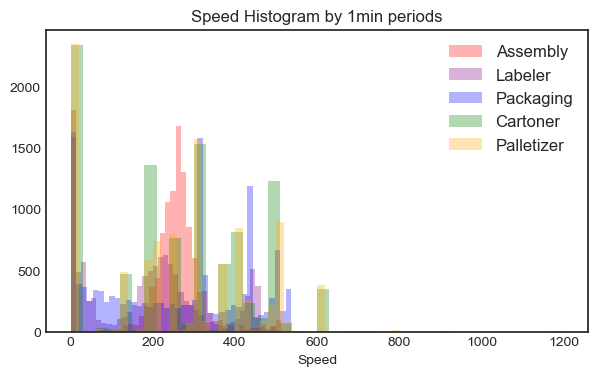

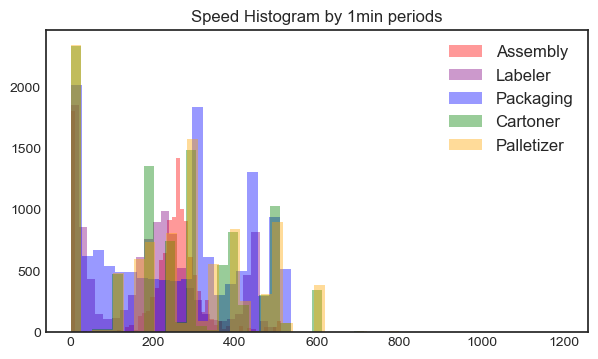

In [242]:
plt.subplots(figsize=(7,4), dpi=100)

freq='1min'

i=0
for x in machines:

    # data = df_speed[df_speed == x].Derived_Speed.sort_values(ascending=False)
    data = df_speed[df_speed.Machine == x].groupby([pd.Grouper(freq=freq)]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    kwargs = dict(histtype='stepfilled', label=x, alpha=0.3, bins=40, color=colors[i])
    plt.hist(data, **kwargs)
    plt.legend()
    # plt.yscale('log')
    i+=1

plt.title('Speed Histogram by {} periods'.format(freq))
# plt.ylabel('{} count'.format(freq))
plt.xlabel('Speed')

plt.subplots(figsize=(7,4), dpi=100)
i=0
for x in machines:

    data = df_speed[df_speed.Machine == x].groupby([pd.Grouper(freq=freq)]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    # data = df_speed.loc[df_speed.Machine == x, 'Derived_Speed'].sort_values(ascending=False)
    sns.distplot (data, color=colors[i], label=x, kde=False)
    i+=1

plt.title('Speed Distplot by {} periods'.format(freq))
plt.legend();


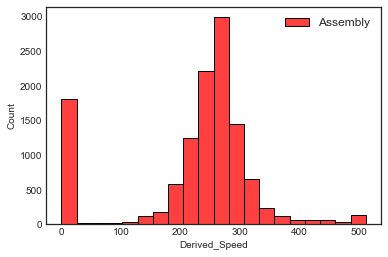

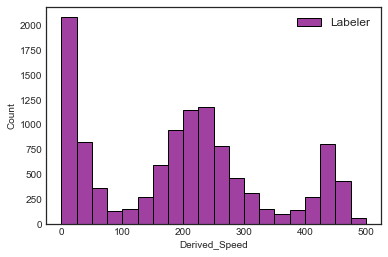

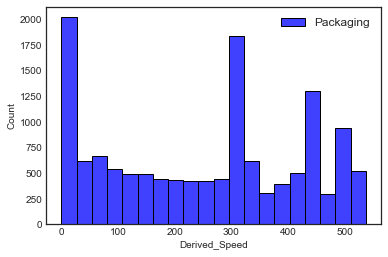

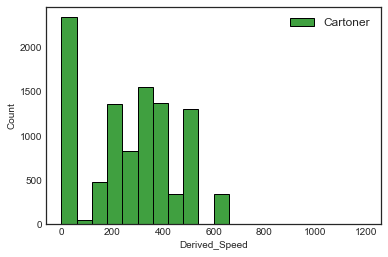

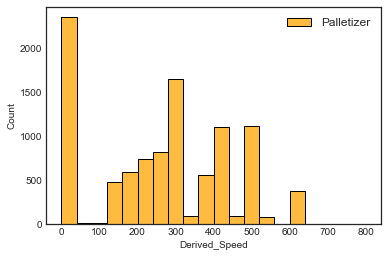

In [387]:
colors = ["red", "purple", "blue", "green", "orange"]

i=0
for x in machines:
    data = df_speed.groupby(['Machine', pd.Grouper(freq='1min')]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    sns.histplot(data[data.Machine == x].Derived_Speed, kde=False, color=colors[i], bins=20, label=x)
    plt.legend()
    plt.show()
    i+=1

In [165]:
# drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_speed_no_sunday = df_speed[(df_speed.index.dayofweek > 0) & (df_speed.index.dayofweek < 5)]

# get Mon between 06:00 and 23:59
df_mon = df_speed[df_speed.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_speed_no_sunday = df_speed_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_speed[df_speed.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_speed_no_sunday = df_speed_no_sunday.append(df_sat)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Packaging'),
  Text(1, 0, 'Assembly'),
  Text(2, 0, 'Labeler'),
  Text(3, 0, 'Cartoner'),
  Text(4, 0, 'Palletizer')])

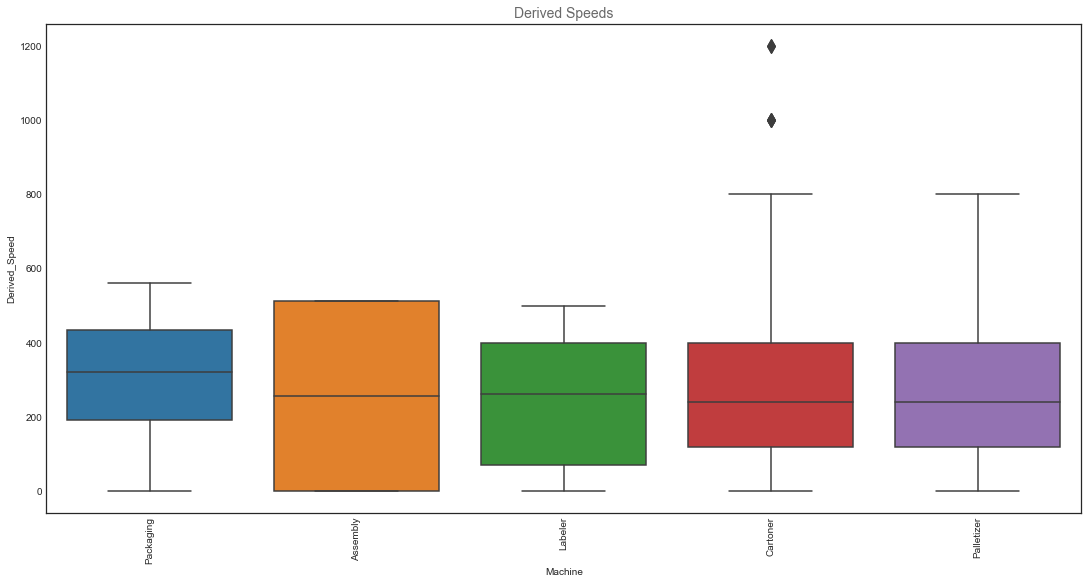

In [187]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 8))

sns.boxplot(x='Machine', y='Derived_Speed', data=df_speed, whis=1.5, fliersize=10).set_title('Derived Speeds', color='dimgrey', size=14)
plt.xticks(rotation=90)